**POSTUP**
1. Filtrace dat pomocí SQL
2. Čištění dat
3. Aplikování OneHotEncoding (OHE) k převedení kategorických dat na binární hodnoty
4. Odstranění přebývajících sloupců zbývajících po OHE
5. Uplatnění SMOTE
6. Vytváření modelů - vybrán model Random Forest
7. Vytvoření dvou skupin z vybraných 5000 a zkoumání poměru mezi nimi
8. Výpočet předpokládané míry konverze

**POPIS**

Our commitment to data-driven marketing has yielded valuable insights to optimize our campaign. We employed advanced techniques like one-hot encoding, SMOTE, and A/B testing to refine our targeting strategy and best data model.

This analysis revealed a critical finding: prioritizing candidates with a high probability of conversion (Group 2) holds significant promise. Compared to the initial focus on high expected revenue alone (Group 1), Group 2 demonstrates best ratio between probability and estimated conversion value.

These data-driven results make us confident that the campaign will achieve successful outcomes.





In [ ]:
import sqlite3
import pandas as pd

# Připojení k SQLite databázi
conn = sqlite3.connect('/content/data.db')

# Načtení dat z určité tabulky do pandas DataFrame
dt_select = '''
SELECT DISTINCT * from Accounts a
LEFT JOIN Campaigns c on a.id = c.account_id
LEFT JOIN Clients cl on a.client_id = cl.id
LEFT JOIN Outcomes o on o.campaign_id = c.id
WHERE a.in_default = 'no' AND c.pdays != -1 AND poutcome != 'unknown'
'''

df = pd.read_sql_query(dt_select, conn)

# Uzavření připojení
conn.close()

df.head(10)

In [ ]:
# We dropped the columns that we do not find as important
df.drop(columns=(['account_id', 'campaign_id','in_default', 'contact', 'id', 'day', 'month', 'duration', 'previous', 'campaign', 'pdays']), inplace=True, axis=0)


In [ ]:
# Uložení DataFrame do CSV souboru
df.to_csv('1_phase_5.csv', index=False)

Převedení kategorických dat na binární za pomoci OneHotEncoding

In [ ]:
# One hot encoding
columns_to_encode = ['housing', 'loan', 'job', 'marital', 'education', 'poutcome', 'y']

df_encoded = pd.get_dummies(df, columns=columns_to_encode)
#df_encoded.tail()

boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)
# Zobrazíme první řádky upraveného dataframe
df_encoded.head()
df_encoded.info()

In [ ]:
df_encoded.head()
# saving the OHE data
df_encoded.to_csv('1_phase_df_encoded.csv', index=False)

In [ ]:
import pandas as pd

# Read the CSV file into a dataframe
df = pd.read_csv('1_phase_df_encoded.csv')

# Display the dataframe
df.head()

In [ ]:
df = df[~(df['poutcome_other'] == 1)]


In [ ]:
columns_to_drop = ['housing_no', 'loan_no', 'client_id', 'education_unknown', 'poutcome_other','poutcome_failure', 'y_no', 'job_unknown']  # Nahraďte názvy sloupců podle potřeby
df = df.drop(columns=columns_to_drop)


In [ ]:
columns_to_drop = ['job_unknown']  # Nahraďte názvy sloupců podle potřeby
df = df.drop(columns=columns_to_drop)

Aplikování SMOTE pro řešení problému s nevyváženým datasetem.

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Rename dataframe to match user's dataframe name

# Separate features and target variable
X = df.drop(columns=['y_yes'])
y = df['y_yes']

# Apply SMOTE for over-sampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Combine resampled features and target variable
df_resampled = pd.concat([X_res, y_res], axis=1)

# Check the distribution of the target variable to ensure balance
resampled_distribution = df_resampled['y_yes'].value_counts()
print(resampled_distribution)

In [ ]:
df.head()

In [ ]:
df_resampled.to_csv('df_SMOTE.csv', index=False)

Vytváření trénovacích modelů

MODELY:
1. LAMINE: Gradient Boosting model
2. HELENA: SVM model
3. SANDRA: Random Forest
4. MAREK:

**LAMINE** - Gradient Boosting

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load Data and Define Target Variable
data = pd.read_csv('df_SMOTE2.csv')

target = 'y_yes'  # Assuming 'y_yes' is the target variable

# Step 2: Preprocess Data

# Check for missing values
missing_values = data.isnull().sum().sum()
print("Missing values:", missing_values)

# Handle missing values if there are any (e.g., fillna or dropna)
# data = data.fillna(method='ffill')  # Example of filling missing values
# Separate features and target
X = data.drop(target, axis=1)
y = data[target]

# Ensure target variable is suitable for classification (optional)
print("Target variable data type:", y.dtype)

# Standardize data (recommended for weighted classifiers)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.6, random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Step 3: Train and Evaluate Logistic Regression Model

# Define and train the Logistic Regression model
model = LogisticRegression(class_weight=class_weights_dict)
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression - Accuracy:", accuracy)
print("Logistic Regression - Precision:", precision)
print("Logistic Regression - Recall:", recall)
print("Logistic Regression - F1-score:", f1)

##############################################################

# Step 4: Identify Top 5000 Likely Buyers

# Predict probabilities for the entire dataset using Logistic Regression
probabilities = model.predict_proba(X_scaled)[:, 1]

# Create a DataFrame with the original data and the predicted probabilities
data_with_prob = data.copy()
data_with_prob['probability'] = probabilities

# Sort the DataFrame by probability in descending order
data_with_prob_sorted = data_with_prob.sort_values(by='probability', ascending=False)

# Select the top 5000 individuals
top_5000 = data_with_prob_sorted.head(5000)

# Display the top 5000 individuals
print(top_5000)

# Optionally, save the top 5000 individuals to a CSV file
top_5000.to_csv('top_5000_customers.csv', index=False)



**HELENA** - SVM model, pipeline, nn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Načtení dat
data = pd.read_csv('/content/df_SMOTE2.csv')

# Předpokládejme, že poslední sloupec je cílová proměnná
X = data.iloc[:, :-1]  # Všechny sloupce kromě posledního
y = data.iloc[:, -1]   # Poslední sloupec

# Rozdělení dat na trénovací a testovací sadu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline pro škálování a trénování modelu
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))  # Nastavení probability=True pro výpočet pravděpodobností
])

# Definování mřížky parametrů pro GridSearch
param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto']
}

# Použití GridSearchCV s 10-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Predikce a vyhodnocení modelu na testovací sadě
y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters found:", grid_search.best_params_)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Výpis matice záměny
con_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(con_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predikce pravděpodobností pro celý dataset
scaler = grid_search.best_estimator_.named_steps['scaler']
svm_model = grid_search.best_estimator_.named_steps['svm']
y_prob_full = svm_model.predict_proba(scaler.transform(X))

print("Predicted probabilities for the entire dataset:\n", y_prob_full)

# Další vyhodnocení modelu
# ROC AUC skóre
y_prob = svm_model.predict_proba(scaler.transform(X_test))
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
print("ROC AUC Score:", roc_auc)

# ROC křivka
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Predikce nových dat
new_data = pd.read_csv('/content/to_clean_cleaned.csv')
new_data_drop = new_data.drop(columns=['client_id', 'y_yes'])


# Predikce pravděpodobností pro nové data
new_predictions = grid_search.best_estimator_.predict_proba(new_data_drop)
print("New Predictions Probabilities:\n", new_predictions)



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Loaded dataset
data = pd.read_csv('/content/df_SMOTE2.csv')

# Data are devided based on the last column: 'y_yes'
X = data.iloc[:, :-1]  # all columns except 'y_yes' column
y = data.iloc[:, -1]   # 'y_yes' column

# Setting data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.model_selection import GridSearchCV

# Definování mřížky parametrů pro GridSearch
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Použití GridSearchCV s 5-fold cross-validation
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Nejlepší parametry a model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found:", best_params)

# Predikce a vyhodnocení nejlepšího modelu
y_pred_best = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


In [ ]:
# Predikce s NN
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Loaded dataset
data = pd.read_csv('/content/df_SMOTE2.csv')

# Data are devided based on the last column: 'y_yes'
X = data.iloc[:, :-1]  # all columns except 'y_yes' column
y = data.iloc[:, -1]   # 'y_yes' column

# Setting data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42)

perceptron = Perceptron(max_iter=5, random_state=42)

perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)
print(y_pred)

print(classification_report(y_test, y_pred))

**SANDRA** - RANDOM FOREST, Pipeline

In [ ]:
# Random Forest model
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/sample_data/df_ready.csv')
data1 = pd.read_csv('df_SMOTE2.csv')
X = data.iloc[:, :-1] # Features
y= data.iloc[:, -1] # Target variable
X_smote = data1.iloc[:, :-1] # Features
y_smote = data1.iloc[:, -1] # Target variable

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Random Forest classifier with 25 trees
clf_25 = RandomForestClassifier(n_estimators=25, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_25.fit(X_train, y_train)
y_pred_25 = clf_25.predict(X_test)
accuracy_25 = accuracy_score(y_test, y_pred_25)
print("Accuracy with 25 trees: {:.2f}%".format(accuracy_25 * 100))

# Random Forest classifier with 25 trees with smote
clf_25_smote = RandomForestClassifier(n_estimators=25, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_25_smote.fit(X_smote_train, y_smote_train)
y_pred_25_smote = clf_25_smote.predict(X_smote_test)
accuracy_25_smote = accuracy_score(y_smote_test, y_pred_25_smote)
print("Accuracy with 25 trees- new dataset: {:.2f}%".format(accuracy_25_smote * 100))

# Random Forest classifier with 50 trees
clf_50 = RandomForestClassifier(n_estimators=50, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_50.fit(X_train, y_train)
y_pred_50 = clf_50.predict(X_test)
accuracy_50 = accuracy_score(y_test, y_pred_50)
print("Accuracy with 50 trees: {:.2f}%".format(accuracy_50 * 100))

# Random Forest classifier with 50 trees with smote
clf_50_smote = RandomForestClassifier(n_estimators=50, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_50_smote.fit(X_smote_train, y_smote_train)
y_pred_50_smote = clf_50_smote.predict(X_smote_test)
accuracy_50_smote = accuracy_score(y_smote_test, y_pred_50_smote)
print("Accuracy with 50 trees- new dataset: {:.2f}%".format(accuracy_50_smote * 100))

# Random Forest classifier with 75 trees
clf_75 = RandomForestClassifier(n_estimators=75, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_75.fit(X_train, y_train)
y_pred_75 = clf_75.predict(X_test)
accuracy_75 = accuracy_score(y_test, y_pred_75)
print("Accuracy with 75 trees: {:.2f}%".format(accuracy_75 * 100))

# Create a Random Forest classifier with 200 trees
clf_200 = RandomForestClassifier(n_estimators=200, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_200.fit(X_train, y_train)
y_pred_200 = clf_200.predict(X_test)
accuracy_200 = accuracy_score(y_test, y_pred_200)
print("Accuracy with 200 trees: {:.2f}%".format(accuracy_200 * 100))

# Create a Random Forest classifier with 200 trees smote
clf_200_smote = RandomForestClassifier(n_estimators=200, criterion='log_loss', min_samples_leaf=4, random_state=42)
clf_200_smote.fit(X_smote_train, y_smote_train)
y_pred_200_smote = clf_200_smote.predict(X_smote_test)
accuracy_200_smote = accuracy_score(y_smote_test, y_pred_200_smote)
print("Accuracy with 200 trees- new dataset: {:.2f}%".format(accuracy_200_smote * 100))

In [ ]:
pipe_rf = Pipeline([
    ('pca', PCA(n_components=2)),
    ('clf', GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid={
            "n_estimators": [75, 50, 100,200],
            "min_samples_split": [2, 3, 4, 5],
            "min_samples_leaf": [1,2,3]},
        cv=5, verbose=0)
    )
])
pipe_rf.fit(X_train,y_train)
y_pred = pipe_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after PCA and GridSearchCV: {:.2f}%".format(accuracy * 100))

**MAREK** - random forest - Tento klasifikační model byl zvolen k predikaci

Overall Accuracy: 0.8453389830508474
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       472
           1       0.86      0.83      0.84       472

    accuracy                           0.85       944
   macro avg       0.85      0.85      0.85       944
weighted avg       0.85      0.85      0.85       944



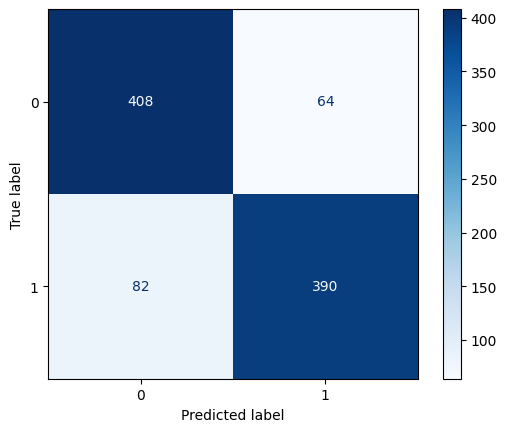

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the data
file_path = 'df_SMOTE2.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['y_yes'])
y = data['y_yes']

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get predictions
y_pred = cross_val_predict(rf_clf, X, y, cv=kf)

# Compute and print the accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Overall Accuracy: {accuracy}")

# Compute and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

# Print the classification report
print("Classification Report:\n", classification_report(y, y_pred))

# Show the plot
plt.show()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load the new dataset
new_file_path = 'to_clean_cleaned.csv'
new_data = pd.read_csv(new_file_path)

# Ensure the new dataset has the same features as the original dataset
# Note: Modify this if necessary to match the actual feature names
new_X = new_data[X.columns]

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the classifier on the original data
rf_clf.fit(X, y)

# Make predictions on the new data
new_y_pred = rf_clf.predict(new_X)

# Add predictions to the new dataset
new_data['Predictions'] = new_y_pred

# Save the new dataset with predictions
output_file_path = 'new_data_with_predictions.csv'
new_data.to_csv(output_file_path, index=False)

print(f"Predictions have been added to the new dataset and saved to {output_file_path}.")

Predictions have been added to the new dataset and saved to new_data_with_predictions.csv.


Získání výsledného datasetu k druhé fázi:

Zkoumání poměrů mezi skupinami:

**Skupina 1** - (Nejvyšší expected revenue při probability alespoň 0,3) (Nejvyšší probability)

**Skupina 2** -  (Nejvyšší probability). K výběru optimální rozložení zisku a míry pravděpodobnosti.







In [ ]:
import pandas as pd
from IPython.display import display

# Načtení nahraného datasetu
file_path = 'Sorted_Client_Data.csv'
df = pd.read_csv(file_path)

# Odstranění duplicit podle client_id
df = df.drop_duplicates(subset='client_id')

# Konverze expected_revenue na numerický typ
df['expected_revenue'] = pd.to_numeric(df['expected_revenue'], errors='coerce')

# Filtrace klientů, kteří nejsou v defaultu
df = df[df['in_default'] == 'no']

# Skupina 1: Klienti s nejvyšším expected_revenue a prob_1 alespoň 0.3
group1 = df[df['prob_1'] >= 0.3].sort_values(by='expected_revenue', ascending=False)

# Skupina 2: Klienti s nejvyšším prob_1
group2 = df.sort_values(by='prob_1', ascending=False)

# Počet klientů v každé skupině
total_clients = 5000

# Výpočet metrik pro různé poměry
results = []

# For Loop, který přiděluje ratio
for g1_ratio in range(11):
    g2_ratio = 10 - g1_ratio
    n_g1 = (g1_ratio * total_clients) // 10
    n_g2 = total_clients - n_g1

    selected_group1 = group1.head(n_g1)
    selected_group2 = group2.head(n_g2)

    combined_group = pd.concat([selected_group1, selected_group2]).drop_duplicates(subset='client_id').head(total_clients)

    avg_prob_1 = combined_group['prob_1'].mean()
    total_expected_revenue = combined_group['expected_revenue'].sum()

    results.append({
        'group1_ratio': g1_ratio / 10,
        'group2_ratio': g2_ratio / 10,
        'avg_prob_1': avg_prob_1,
        'total_expected_revenue': total_expected_revenue
    })

# Převod výsledků na DataFrame pro snadnou analýzu
results_df = pd.DataFrame(results)

# Zobrazení DataFrame
display(results_df)

# Výběr top 5000 klientů podle prob_1
top_5000_clients = df.nlargest(5000, 'prob_1')

# Výpočet průměrné hodnoty prob_1 a celkových očekávaných příjmů
average_prob_1 = top_5000_clients['prob_1'].mean()
total_expected_revenue = top_5000_clients['expected_revenue'].sum()

print(f'Average prob_1: {average_prob_1}')
print(f'Total expected revenue: {total_expected_revenue}')

# Uložení top 5000 klientů do nového CSV souboru
output_file_path = 'Top_5000_Clients.csv'
top_5000_clients.to_csv(output_file_path, index=False)

In [ ]:
import pandas as pd

# Načtení CSV souboru
file_path = 'Sorted_Client_Data.csv'
data = pd.read_csv(file_path)

# Výběr top 5000 klientů podle prob_1
top_5000_clients = data.nlargest(5000, 'prob_1')

# Výpočet průměrné hodnoty prob_1 a celkových očekávaných příjmů
average_prob_1 = top_5000_clients['prob_1'].mean()
total_expected_revenue = top_5000_clients['expected_revenue'].sum()

print(f'Average prob_1: {average_prob_1}')
print(f'Total expected revenue: {total_expected_revenue}')

# Uložení top 5000 klientů do nového CSV souboru
output_file_path = 'Top_5000_Clients.csv'
top_5000_clients.to_csv(output_file_path, index=False)

# Kód pro stažení souboru
import shutil

def download_file(file_path, output_path):
    shutil.copy(file_path, output_path)
    print(f'Soubor byl uložen na: {output_path}')

Výpočet předpokládané míry konverze


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Load the CSV file
data = pd.read_csv('Top_5000_Clients.csv')

# Display the first few rows of the dataframe
print(data.head())

def calculate_estimated_conversion(df):

    # Calculate the estimated conversion rate
    estimated_conversion_rate = df['prob_1'].mean()

    # Calculate the estimated conversion value
    estimated_conversion_value = (df['prob_1'] * df['monthly_income']).sum()

    return estimated_conversion_rate, estimated_conversion_value

# Perform the calculation
estimated_conversion_rate, estimated_conversion_value = calculate_estimated_conversion(data)

print(f"Estimated Conversion Rate: {estimated_conversion_rate * 100:.2f}%")
print(f"Estimated Conversion Value: {estimated_conversion_value:.2f}")